<a href="https://colab.research.google.com/github/dominikklepl/Neural-Networks-Intracranial-hemorrhage-detection/blob/master/04_CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building CNN from scratch
In previous notebook, we built only the classifier part of the model and used pretrainted convolutional layers for automatic feature extraction.

We'll just copy paste functions for preprocessing and data generation from previous notebook ("03 Transfer learning")

In [0]:
prototyping = False

## Setup and paths to data

Install missing packages

In [2]:
!pip install pydicom

     |████████████████████████████████| 7.1MB 8.8MB/s 


Import all required packages

In [3]:
#connect google drive
from google.colab import drive

#dealing with zip
import zipfile

#importing labels and working with dataframe
import pandas as pd

#manipulation with images
import pydicom
import torch
import numpy as np
from math import ceil, floor, log
import cv2

#train-test
from sklearn.model_selection import GroupKFold

#models
%tensorflow_version 1.x
import keras.utils
import tensorflow as tf
print(tf.__version__)
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout, Conv2D, MaxPooling2D, Input, BatchNormalization, SpatialDropout2D
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from tensorflow.nn import sigmoid_cross_entropy_with_logits

#save model architecture
from contextlib import redirect_stdout

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


1.15.0


In [0]:
#ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Check that GPU is available and that keras can use it.

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Set random seed for reproducibility

In [0]:
np.random.seed(31415)

Connect Google Drive. That's where my data is stored.

In [7]:
GDRIVE_PATH = "/gdrive"
drive.mount(GDRIVE_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Set paths to all required data

In [8]:
WORK_DIR = "/content/"
BASE_DIR = GDRIVE_PATH + "/My Drive/"
ZIP_PATH = BASE_DIR + "DICOMS/train_images.zip"
DF_PATH = BASE_DIR + "train_balanced.csv"
MODEL_PATH = BASE_DIR + "models/"
RESULT_PATH = BASE_DIR + "results/" #for saving performance of models
IMAGES_PATH = WORK_DIR + "img"

#if the model and results aren't created already, create them
!mkdir /gdrive/My\ Drive/models
!mkdir /gdrive/My\ Drive/results

#also create temporary folder in working directory for unzipping images
!mkdir /content/img

mkdir: cannot create directory ‘/gdrive/My Drive/models’: File exists
mkdir: cannot create directory ‘/gdrive/My Drive/results’: File exists


In [9]:
#get number of CPU cores
import multiprocessing
CORES = multiprocessing.cpu_count()
print(CORES)

2


Images are saved in a zip file. For easier and faster manipulation, let's extract them to a folder in the working directory that we created before ("/content/img")

In [10]:
img_archive = zipfile.ZipFile(ZIP_PATH)
%time img_archive.extractall(path=IMAGES_PATH)

CPU times: user 13min 2s, sys: 2min 25s, total: 15min 27s
Wall time: 21min 21s


### Load the csv with labels and metadata

In [11]:
train_df = pd.read_csv(DF_PATH)
train_df.sample(3)

Unnamed: 0  Unnamed: 0.1   index  ... subdural     pct_cut split
139665      139665        139665  312002  ...        0  (0.1, 0.2]    14
148871      148871        148871  427720  ...        0  (0.2, 0.3]    15
40455        40455         40455  281098  ...        1  (0.3, 1.0]     5

[3 rows x 53 columns]

Some of the columns are useless at this point, let's keep just those that we actually need. Also some of the columns have too long name, yes SOPInstanceUID I'm talking about you so we'll rename them.

In [0]:
train = train_df[['SOPInstanceUID',
                  'PatientID',
                  'any',
                  'epidural',
                  'intraparenchymal',
                  'intraventricular',
                  'subarachnoid',
                  'subdural']].copy()
train.rename(columns={'SOPInstanceUID': 'ID',
                      'PatientID': 'Patient'},
              inplace=True)
train = train.sample(frac=1, random_state=1)

In [0]:
if prototyping:
  train = train.sample(200)
  train = train.reset_index(drop=True)

In [14]:
train.head(5)

ID      Patient  ...  subarachnoid  subdural
30631   ID_f2e95fbce  ID_b8d82bc8  ...             0         1
121378  ID_97716b96f  ID_55513c6e  ...             0         0
160098  ID_f3e24d19d  ID_0430194e  ...             0         0
65925   ID_21a834970  ID_e7522668  ...             0         1
36787   ID_cfff53a3d  ID_96f7a151  ...             0         1

[5 rows x 8 columns]

### Load bins for uniform transform

In [0]:
bins = torch.load(BASE_DIR+"bins.pt").numpy()

## Data processing functions
Before we can start building awesome neural networks, we need a few helper functions for constructing data (i.e. images) in form that's acceptable for the models to learn from.

First, functions for reading DICOM and applying intercept and slope.

In [0]:
#correcting dcm with wrong meta-data (explained in preprocessing notebook)
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

#transform dicom to HU by applying intercept and slope
def rescale_dcm(dcm):
  if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
    correct_dcm(dcm)
  return dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept

### Use full scale but apply uniform distribution

In [0]:
def to_full(dcm, bins):
  ys = np.linspace(0., 1., len(bins))
  x = dcm.flatten()
  x = np.interp(x, bins, ys)
  x = x.reshape(dcm.shape).clip(0.,1.) * 2**16
  x = x.astype(np.uint16)
  x[x<np.median(x)]=0
  x = np.stack((x,)*3, axis=-1)
  return x

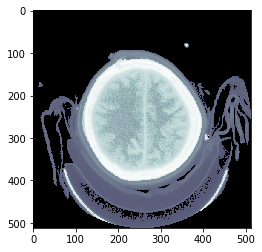

In [18]:
#test it
dcm = pydicom.dcmread(IMAGES_PATH+"/"+train.ID[0]+".dcm")
dcm = rescale_dcm(dcm)
x = to_full(dcm, bins)
plt.imshow(x[:,:,0], cmap=plt.cm.bone)

### Getting channels and save them as color channels

In [0]:
def window_image(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    ue = np.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def to_channels(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

In [0]:
#Finally function for loading a single image and resizing it to the input size.
def read_img(ID, resize, preprocess):
    path = IMAGES_PATH+'/'+ID+'.dcm'
    dcm = pydicom.dcmread(path)
    dcm = rescale_dcm(dcm)

    if preprocess is "CH":
      try: img = to_channels(dcm)
      except: img = np.zeros(resize)
    if preprocess is "F":
      try: img = to_full(dcm, bins)
      except: img = np.zeros(resize)

    img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_CUBIC) #resize
    img = (img - np.min(img))/(np.max(img)-np.min(img)) #min-max normalize
    return img

CPU times: user 68.6 ms, sys: 978 µs, total: 69.6 ms
Wall time: 121 ms
CPU times: user 14.1 ms, sys: 2.02 ms, total: 16.1 ms
Wall time: 16.1 ms
(250, 250, 3)


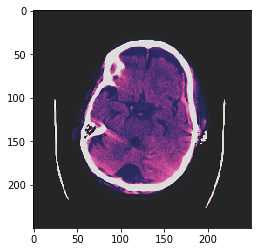

In [21]:
%time img_ch = read_img(train.ID[2], (250, 250, 3), preprocess="CH")
%time img_f = read_img(train.ID[2], (250, 250, 3), preprocess="F")

#some sanity checks
plt.imshow(img_ch)
print(img_ch.shape)

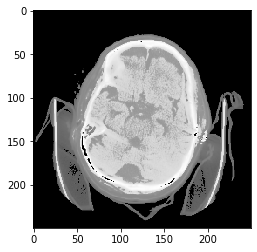

In [22]:
plt.imshow(img_f)

### Data generator
This function prepares each batch for feeding to neural network. First, it gets random IDs and associated labels. Then shuffles them, to reduce bias. Finally, the images, using the IDs are loaded using the _read function defined above.

The function is generalized for both training and testing data.

It is derived from keras.sequence so it should be enabled for multiprocessing.

#### Full-preprocessing DataGenerator

In [0]:
class DataGenerator_Full(keras.utils.Sequence):

    def __init__(self, IDs, labels=None, batch_size=30, img_size=(299, 299, 3), num_classes=5, steps=100, *args, **kwargs):
        self.IDs = IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.on_epoch_end()
        self.steps = steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3

#define number of steps per epoch
    def __len__(self):
      if self.steps is None:
        return np.int(np.ceil(len(self.IDs) / np.float(self.batch_size)))
      else:
        return 3*np.int(self.steps/3) 

    def __getitem__(self, index):
        IDs_batch = self.IDs[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
          X, y_any, y_subtype = self.__data_generation(IDs_batch)
          return X, [y_any, y_subtype]
        else:
            X = self.__data_generation(IDs_batch)
            return X
        
    def on_epoch_end(self):
        if self.labels is not None: #during training we shuffle the images
            self.indices = np.arange(len(self.IDs))
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.IDs))

    def __data_generation(self, IDs_batch):
        X = np.empty((self.batch_size, *self.img_size))
        if self.labels is not None: # training
          y_subtype = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
          y_any = np.empty((self.batch_size, 1), dtype=np.float32)
          for i, ID in enumerate(IDs_batch):
            X[i,] = read_img(ID, self.img_size, preprocess="F")
            y_any[i], y_subtype[i] = self.__get_target(ID)
          return X, y_any, y_subtype
        else: # testing
            for i, ID in enumerate(IDs_batch):
                X[i,] = read_img(ID, self.img_size, preprocess="F")
            return X

    def __get_target(self, ID):
        y_any = self.labels.loc[ID, "any"]
        y_subtype = self.labels.drop("any", axis=1).loc[ID].values
        return y_any, y_subtype

#### Channels-preprocessing DataGenerator

In [0]:
class DataGenerator_Channels(keras.utils.Sequence):

    def __init__(self, IDs, labels=None, batch_size=30, img_size=(299, 299, 3), num_classes=5, steps=100, *args, **kwargs):
        self.IDs = IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.on_epoch_end()
        
        self.steps = steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3

#define number of steps per epoch
    def __len__(self):
      if self.steps is None:
        return np.int(np.ceil(len(self.IDs) / np.float(self.batch_size)))
      else:
        return 3*np.int(self.steps/3) 

    def __getitem__(self, index):
        IDs_batch = self.IDs[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
          X, y_any, y_subtype = self.__data_generation(IDs_batch)
          return X, [y_any, y_subtype]
        else:
            X = self.__data_generation(IDs_batch)
            return X
        
    def on_epoch_end(self):
        if self.labels is not None: #during training we shuffle the images
            self.indices = np.arange(len(self.IDs))
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.IDs))

    def __data_generation(self, IDs_batch):
        X = np.empty((self.batch_size, *self.img_size))
        if self.labels is not None: # training
          y_subtype = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
          y_any = np.empty((self.batch_size, 1), dtype=np.float32)
          for i, ID in enumerate(IDs_batch):
            X[i,] = read_img(ID, self.img_size, preprocess="CH")
            y_any[i], y_subtype[i] = self.__get_target(ID)
          return X, y_any, y_subtype
        else: # testing
            for i, ID in enumerate(IDs_batch):
                X[i,] = read_img(ID, self.img_size, preprocess="CH")
            return X

    def __get_target(self, ID):
        y_any = self.labels.loc[ID, "any"]
        y_subtype = self.labels.drop("any", axis=1).loc[ID].values
        return y_any, y_subtype

## Train-test split
We'll save 10% of images for testing.

In [25]:
group_kfold = GroupKFold(n_splits=10)

for tr, ts in group_kfold.split(train, groups=train.Patient):
  training = train.iloc[tr]
  testing = train.iloc[ts]

testing = testing.set_index('ID', drop=False)
print(training.shape)
print(testing.shape)

(174674, 8)
(19408, 8)


### Train-validation split

In [26]:
tr_val_folds = GroupKFold(n_splits=20)

for tr, ts in tr_val_folds.split(training, groups=training.Patient):
  train_data = training.iloc[tr]
  val_data = training.iloc[ts]

train_data = train_data.set_index('ID', drop=False)
val_data = val_data.set_index('ID', drop=False)
print(train_data.shape)
print(val_data.shape)

(165941, 8)
(8733, 8)


### Data generators

In [0]:
train_dataloader_CH = DataGenerator_Channels(IDs=train_data.ID,
                                 labels=train_data.loc[:,'any':'subdural'],
                                 batch_size=20,
                                 img_size=(299,299,3),
                                 num_classes=5)
val_dataloader_CH = DataGenerator_Channels(IDs=val_data.ID,
                               labels=val_data.loc[:,'any':'subdural'],
                               batch_size=10,
                               img_size=(299,299,3),
                               num_classes=5)

train_dataloader_F = DataGenerator_Full(IDs=train_data.ID,
                                 labels=train_data.loc[:,'any':'subdural'],
                                 batch_size=20,
                                 img_size=(299,299,3),
                                 num_classes=5)
val_dataloader_F = DataGenerator_Full(IDs=val_data.ID,
                               labels=val_data.loc[:,'any':'subdural'],
                               batch_size=10,
                               img_size=(299,299,3),
                               num_classes=5)

In [40]:
#sanity check of datagenerator
%time X, [y1, y2] = train_dataloader_F.__getitem__(0)

CPU times: user 364 ms, sys: 20.1 ms, total: 384 ms
Wall time: 494 ms


In [29]:
print(X.shape)
print(y1.shape)
print(y2.shape)

(20, 299, 299, 3)
(20, 1)
(20, 5)


In [41]:
y1

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

## Loss function

In [0]:
def np_multilabel_loss(y_true, y_pred, class_weights=np.array([1., 1., 1., 1., 1.])):
    y_pred = np.where(y_pred > 1-(1e-07), 1-1e-07, y_pred)
    y_pred = np.where(y_pred < 1e-07, 1e-07, y_pred)
    single_class_cross_entropies = - np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred), axis=0)
    
    print(single_class_cross_entropies)
    if class_weights is None:
        loss = np.mean(single_class_cross_entropies)
    else:
        loss = np.sum(class_weights*single_class_cross_entropies)
    return loss

## Define CNN architecture

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,min_lr=1e-8,mode="min")
        
e_stopping = EarlyStopping(monitor="val_loss",min_delta=0.01,patience=5,mode="min")

kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

def build_model_1():
  inputs = Input(shape=(299,299,3))
  x = Conv2D(60, kernel_size=(5,5), strides=(2,2),activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(inputs)
  x = SpatialDropout2D(rate=0.3, data_format='channels_last')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(3, 3))(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.4)(x)
  x = Dense(60, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(30, activation='relu')(x)
  x = Dropout(0.3)(x)
  any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
  any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
  x = concatenate([any_pred, x])
  sub_pred = Dense(5, name="subtype_pred",
                   kernel_initializer=he_normal(seed=12),
                   activation="sigmoid")(x) 
  model = Model(inputs=inputs, outputs=[any_pred, sub_pred])
  model.compile(optimizer=Adam(1e-3),
                loss=['binary_crossentropy', 'binary_crossentropy'],
                loss_weights = [0.7, 0.3],
                metrics={"any_predictions":"binary_accuracy",
                         "subtype_pred": "categorical_accuracy"})
  return model

def build_model_2():
  inputs = Input(shape=(299,299,3))
  x = Conv2D(60, kernel_size=(5,5), strides=(2,2),activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(inputs)
  x = SpatialDropout2D(rate=0.3, data_format='channels_last')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(3, 3))(x)
  x = Conv2D(50, kernel_size=(3,3), strides=(2,2), activation='relu',kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  x = SpatialDropout2D(rate=0.3, data_format='channels_last')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.4)(x)
  x = Dense(50, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(30, activation='relu')(x)
  x = Dropout(0.3)(x)
  any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
  any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
  x = concatenate([any_pred, x])
  sub_pred = Dense(5, name="subtype_pred",
                   kernel_initializer=he_normal(seed=12),
                   activation="sigmoid")(x) 
  model = Model(inputs=inputs, outputs=[any_pred, sub_pred])
  model.compile(optimizer=Adam(1e-3),
                loss=['binary_crossentropy', 'binary_crossentropy'],
                loss_weights = [0.7, 0.3],
                metrics={"any_predictions":"binary_accuracy",
                         "subtype_pred": "categorical_accuracy"})
  return model


def build_model_3():
  inputs = Input(shape=(299,299,3))
  x = Conv2D(60, kernel_size=(5,5), strides=(2,2),activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(inputs)
  x = SpatialDropout2D(rate=0.3, data_format='channels_last')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(3, 3))(x)
  x = Conv2D(100, kernel_size=(3,3), strides=(2,2), activation='relu',kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  x = SpatialDropout2D(rate=0.3, data_format='channels_last')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Conv2D(50, kernel_size=(2,2), strides=(2,2), activation='relu',kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  x = SpatialDropout2D(rate=0.3, data_format='channels_last')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.4)(x)
  x = Dense(50, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(30, activation='relu')(x)
  x = Dropout(0.3)(x)
  any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
  any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
  x = concatenate([any_pred, x])
  sub_pred = Dense(5, name="subtype_pred",
                   kernel_initializer=he_normal(seed=12),
                   activation="sigmoid")(x) 
  model = Model(inputs=inputs, outputs=[any_pred, sub_pred])
  model.compile(optimizer=Adam(1e-3),
                loss=['binary_crossentropy', 'binary_crossentropy'],
                loss_weights = [0.7, 0.3],
                metrics={"any_predictions":"binary_accuracy",
                         "subtype_pred": "categorical_accuracy"})
  return model

## Fit models with channel images

In [0]:
EPOCHS = 30

In [34]:
model_CH_1 = build_model_1()
history_CH_1 = model_CH_1.fit_generator(generator=train_dataloader_CH,
                              validation_data=val_dataloader_CH,
                              epochs=EPOCHS,
                              callbacks=[reduce_lr, e_stopping])

model_CH_2 = build_model_2()
history_CH_2 = model_CH_2.fit_generator(generator=train_dataloader_CH,
                              validation_data=val_dataloader_CH,
                              epochs=EPOCHS,
                              callbacks=[reduce_lr, e_stopping])

model_CH_3 = build_model_3()
history_CH_3 = model_CH_3.fit_generator(generator=train_dataloader_CH,
                              validation_data=val_dataloader_CH,
                              epochs=EPOCHS,
                              callbacks=[reduce_lr, e_stopping])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30


21/99 [=====>........................] - ETA: 2:18 - loss: 0.8141 - any_predictions_loss: 0.7913 - subtype_pred_loss: 0.8671 - any_predictions_binary_accuracy: 0.5048 - subtype_pred_categorical_accuracy: 0.1476

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


99/99 [==============================] - 225s 2s/step - loss: 0.7162 - any_predictions_loss: 0.7492 - subtype_pred_loss: 0.6393 - any_predictions_binary_accuracy: 0.5091 - subtype_pred_categorical_accuracy: 0.1894 - val_loss: 0.6511 - val_any_predictions_loss: 0.6932 - val_subtype_pred_loss: 0.5528 - val_any_predictions_binary_accuracy: 0.5051 - val_subtype_pred_categorical_accuracy: 0.0818
Epoch 2/30
99/99 [==============================] - 186s 2s/step - loss: 0.6402 - any_predictions_loss: 0.7147 - subtype_pred_loss: 0.4665 - any_predictions_binary_accuracy: 0.5131 - subtype_pred_categorical_accuracy: 0.1843 - val_loss: 0.6271 - val_any_predictions_loss: 0.6947 - val_subtype_pred_loss: 0.4694 - val_any_predictions_binary_accuracy: 0.5040 - val_subtype_pred_categorical_accuracy: 0.0828
Epoch 3/30
99/99 [==============================] - 186s 2s/step - loss: 0.6284 - any_predictions_loss: 0.7151 - subtype_pred_loss: 0.4261 - any_predictions_binary_accuracy: 0.5091 - subtype_pred_categ

In [35]:
losses_ch = {"M1": abs(min(history_CH_1.history['val_loss'])),
             "M2": abs(min(history_CH_2.history['val_loss'])),
             "M3": abs(min(history_CH_3.history['val_loss']))
}

best_ch = min(losses_ch.keys(), key=(lambda k: losses_ch[k]))
print(best_ch)

M2


Save history to csv for later and also the model architecture and learned weights.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


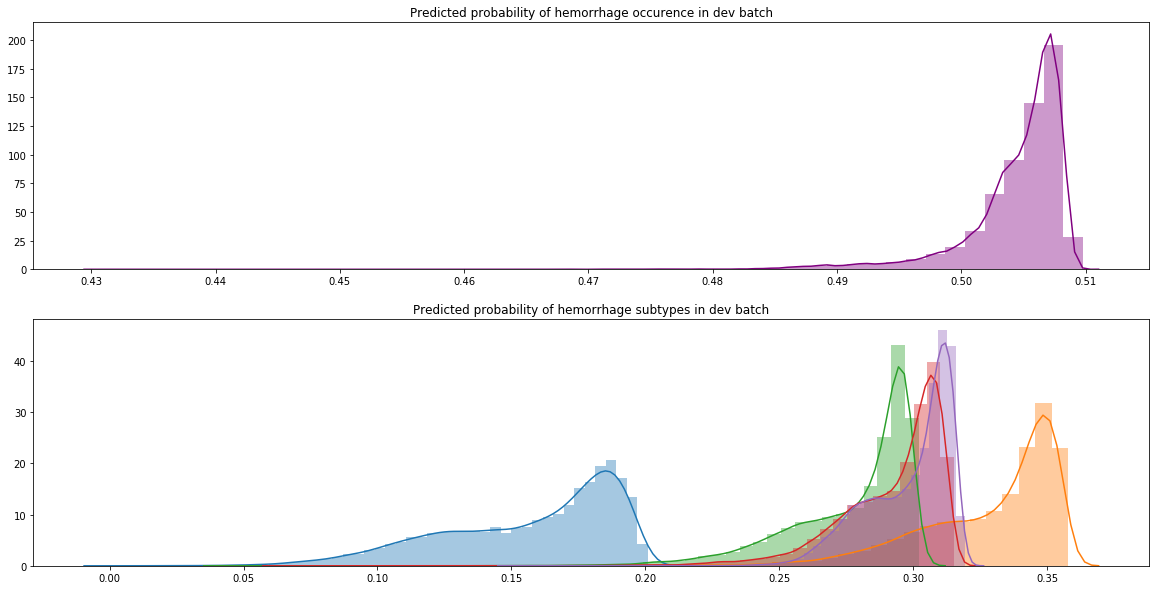

In [36]:
if best_ch is 'M1':
  channels_history = pd.DataFrame.from_dict(history_CH_1.history)
  channels_history['epoch']=history_CH_1.epoch
  channels_history = channels_history.set_index('epoch')
  channels_history.head(5)

  #save history to csv
  channels_history.to_csv(RESULT_PATH + 'history_CNN_channels.csv')

  #save weights
  model_CH_1.save_weights(MODEL_PATH + "CNN_channels.h5")

  with open(MODEL_PATH + 'CNN_channels_summary.txt', 'w') as f:
      with redirect_stdout(f):
          model_CH_1.summary()

  test_dataloader_CH = DataGenerator_Channels(IDs=testing.ID,
                                batch_size=10,
                                img_size=(299,299,3),
                                num_classes=5,
                                steps=None)
  CH_test_pred_any, CH_test_pred_sub = model_CH_1.predict(test_dataloader_CH)
  any_pred = pd.DataFrame(CH_test_pred_any)
  sub_pred = pd.DataFrame(CH_test_pred_sub)
  ID = pd.DataFrame(testing.ID.values)
  channels_pred = pd.concat([ID,any_pred, sub_pred], axis=1)
  channels_pred.columns = ["ID", "any", 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
  channels_pred.to_csv(RESULT_PATH + "CNN_channels_preds.csv")
  fig, ax = plt.subplots(2,1, figsize=(20,10))
  sns.distplot(CH_test_pred_any[:,0], ax=ax[0], color="Purple")
  sns.distplot(CH_test_pred_sub[:,0], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,1], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,2], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,3], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,4], ax=ax[1])
  ax[0].set_title("Predicted probability of hemorrhage occurence in dev batch")
  ax[1].set_title("Predicted probability of hemorrhage subtypes in dev batch")
  fig.savefig(RESULT_PATH + 'CNN_channels_dist.png')

if best_ch is 'M2':
  channels_history = pd.DataFrame.from_dict(history_CH_2.history)
  channels_history['epoch']=history_CH_2.epoch
  channels_history = channels_history.set_index('epoch')

  #save history to csv
  channels_history.to_csv(RESULT_PATH + 'history_CNN_channels.csv')

  #save weights
  model_CH_2.save_weights(MODEL_PATH + "CNN_channels.h5")

  with open(MODEL_PATH + 'CNN_channels_summary.txt', 'w') as f:
      with redirect_stdout(f):
          model_CH_2.summary()

  test_dataloader_CH = DataGenerator_Channels(IDs=testing.ID,
                                batch_size=10,
                                img_size=(299,299,3),
                                num_classes=5,
                                steps=None)
  CH_test_pred_any, CH_test_pred_sub = model_CH_2.predict(test_dataloader_CH)
  any_pred = pd.DataFrame(CH_test_pred_any)
  sub_pred = pd.DataFrame(CH_test_pred_sub)
  ID = pd.DataFrame(testing.ID.values)
  channels_pred = pd.concat([ID,any_pred, sub_pred], axis=1)
  channels_pred.columns = ["ID", "any", 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
  channels_pred.to_csv(RESULT_PATH + "CNN_channels_preds.csv")
  fig, ax = plt.subplots(2,1, figsize=(20,10))
  sns.distplot(CH_test_pred_any[:,0], ax=ax[0], color="Purple")
  sns.distplot(CH_test_pred_sub[:,0], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,1], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,2], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,3], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,4], ax=ax[1])
  ax[0].set_title("Predicted probability of hemorrhage occurence in dev batch")
  ax[1].set_title("Predicted probability of hemorrhage subtypes in dev batch")
  fig.savefig(RESULT_PATH + 'CNN_channels_dist.png')

if best_ch is 'M3':
  channels_history = pd.DataFrame.from_dict(history_CH_3.history)
  channels_history['epoch']=history_CH_3.epoch
  channels_history = channels_history.set_index('epoch')
  channels_history.head(5)

  #save history to csv
  channels_history.to_csv(RESULT_PATH + 'history_CNN_channels.csv')

  #save weights
  model_CH_3.save_weights(MODEL_PATH + "CNN_channels.h5")

  with open(MODEL_PATH + 'CNN_channels_summary.txt', 'w') as f:
      with redirect_stdout(f):
          model_CH_3.summary()

  test_dataloader_CH = DataGenerator_Channels(IDs=testing.ID,
                                batch_size=10,
                                img_size=(299,299,3),
                                num_classes=5,
                                steps=None)
  CH_test_pred_any, CH_test_pred_sub = model_CH_3.predict(test_dataloader_CH)
  any_pred = pd.DataFrame(CH_test_pred_any)
  sub_pred = pd.DataFrame(CH_test_pred_sub)
  ID = pd.DataFrame(testing.ID.values)
  channels_pred = pd.concat([ID,any_pred, sub_pred], axis=1)
  channels_pred.columns = ["ID", "any", 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
  channels_pred.to_csv(RESULT_PATH + "CNN_channels_preds.csv")
  fig, ax = plt.subplots(2,1, figsize=(20,10))
  sns.distplot(CH_test_pred_any[:,0], ax=ax[0], color="Purple")
  sns.distplot(CH_test_pred_sub[:,0], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,1], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,2], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,3], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,4], ax=ax[1])
  ax[0].set_title("Predicted probability of hemorrhage occurence in dev batch")
  ax[1].set_title("Predicted probability of hemorrhage subtypes in dev batch")
  fig.savefig(RESULT_PATH + 'CNN_channels_dist.png')

## Fit models with full images

In [42]:
model_F_1 = build_model_1()
history_F_1 = model_F_1.fit_generator(generator=train_dataloader_F,
                              validation_data=val_dataloader_F,
                              epochs=EPOCHS,
                              callbacks=[reduce_lr, e_stopping])

model_F_2 = build_model_2()
history_F_2 = model_F_2.fit_generator(generator=train_dataloader_F,
                              validation_data=val_dataloader_F,
                              epochs=EPOCHS,
                              callbacks=[reduce_lr, e_stopping])

model_F_3 = build_model_3()
history_F_3 = model_F_3.fit_generator(generator=train_dataloader_F,
                              validation_data=val_dataloader_F,
                              epochs=EPOCHS,
                              callbacks=[reduce_lr, e_stopping])

Epoch 1/30
99/99 [==============================] - 74s 747ms/step - loss: 0.7074 - any_predictions_loss: 0.7605 - subtype_pred_loss: 0.5833 - any_predictions_binary_accuracy: 0.4939 - subtype_pred_categorical_accuracy: 0.1747 - val_loss: 0.6529 - val_any_predictions_loss: 0.6926 - val_subtype_pred_loss: 0.5601 - val_any_predictions_binary_accuracy: 0.5273 - val_subtype_pred_categorical_accuracy: 0.1414
Epoch 2/30
99/99 [==============================] - 50s 509ms/step - loss: 0.6419 - any_predictions_loss: 0.7214 - subtype_pred_loss: 0.4564 - any_predictions_binary_accuracy: 0.5091 - subtype_pred_categorical_accuracy: 0.1768 - val_loss: 0.6434 - val_any_predictions_loss: 0.6930 - val_subtype_pred_loss: 0.5276 - val_any_predictions_binary_accuracy: 0.5061 - val_subtype_pred_categorical_accuracy: 0.1525
Epoch 3/30
99/99 [==============================] - 50s 505ms/step - loss: 0.6336 - any_predictions_loss: 0.7186 - subtype_pred_loss: 0.4352 - any_predictions_binary_accuracy: 0.4960 - s

### Select the best model to save its output

In [43]:
losses_f = {"M1": abs(min(history_F_1.history['val_loss'])),
             "M2": abs(min(history_F_2.history['val_loss'])),
             "M3": abs(min(history_F_3.history['val_loss']))
}

best_f = min(losses_f.keys(), key=(lambda k: losses_f[k]))
print(best_f)

M3


Save history for later and also the model architecture and learned weights

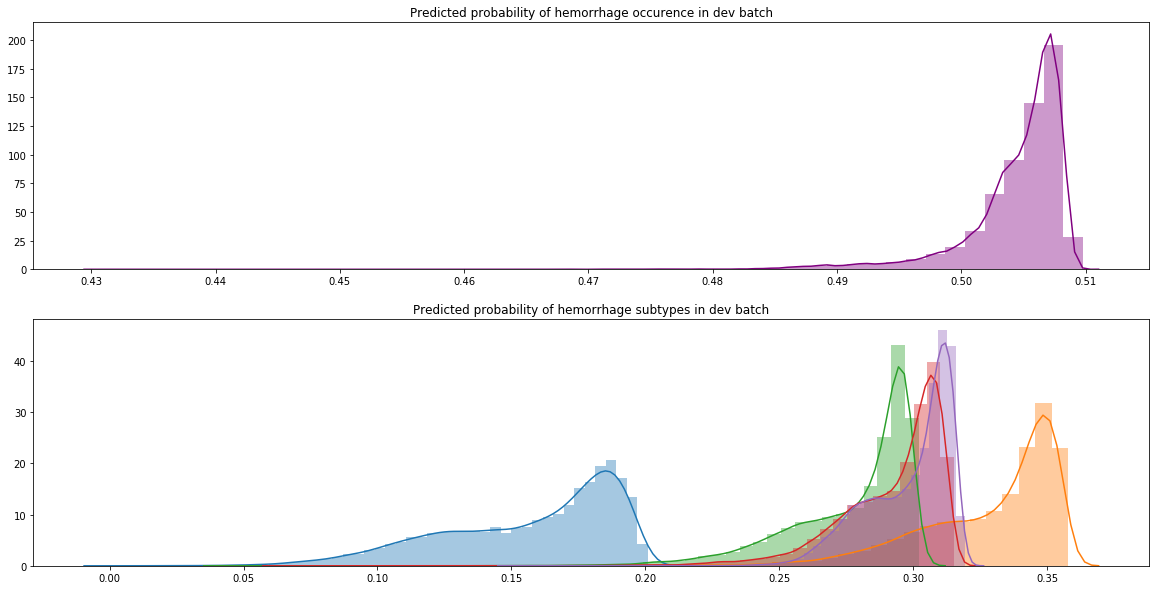

In [44]:
if best_f is 'M1':
  full_history = pd.DataFrame.from_dict(history_F_1.history)
  full_history['epoch']=history_F_1.epoch
  full_history = full_history.set_index('epoch')
  full_history.head(5)

  #save history to csv
  full_history.to_csv(RESULT_PATH + 'history_CNN_full.csv')

  #save weights
  model_F_1.save_weights(MODEL_PATH + "CNN_full.h5")

  with open(MODEL_PATH + 'CNN_full_summary.txt', 'w') as f:
      with redirect_stdout(f):
          model_F_1.summary()

  test_dataloader_F = DataGenerator_Full(IDs=testing.ID,
                                batch_size=5,
                                img_size=(299,299,3),
                                num_classes=5,
                                steps=None)
  F_test_pred_any, F_test_pred_sub = model_F_1.predict(test_dataloader_F)
  any_pred = pd.DataFrame(F_test_pred_any)
  sub_pred = pd.DataFrame(F_test_pred_sub)
  ID = pd.DataFrame(testing.ID.values)
  full_pred = pd.concat([ID,any_pred, sub_pred], axis=1)
  full_pred.columns = ["ID", "any", 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
  full_pred.to_csv(RESULT_PATH + "CNN_full_preds.csv")
  fig, ax = plt.subplots(2,1, figsize=(20,10))
  sns.distplot(CH_test_pred_any[:,0], ax=ax[0], color="Purple")
  sns.distplot(CH_test_pred_sub[:,0], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,1], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,2], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,3], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,4], ax=ax[1])
  ax[0].set_title("Predicted probability of hemorrhage occurence in dev batch")
  ax[1].set_title("Predicted probability of hemorrhage subtypes in dev batch")
  fig.savefig(RESULT_PATH + 'CNN_full_dist.png')

if best_f is 'M2':
  full_history = pd.DataFrame.from_dict(history_F_2.history)
  full_history['epoch']=history_F_2.epoch
  full_history = full_history.set_index('epoch')

  #save history to csv
  full_history.to_csv(RESULT_PATH + 'history_CNN_full.csv')

  #save weights
  model_F_2.save_weights(MODEL_PATH + "CNN_full.h5")

  with open(MODEL_PATH + 'CNN_full_summary.txt', 'w') as f:
      with redirect_stdout(f):
          model_F_2.summary()

  test_dataloader_F = DataGenerator_Full(IDs=testing.ID,
                                batch_size=5,
                                img_size=(299,299,3),
                                num_classes=5,
                                steps=None)
  F_test_pred_any, F_test_pred_sub = model_F_2.predict(test_dataloader_F)
  any_pred = pd.DataFrame(F_test_pred_any)
  sub_pred = pd.DataFrame(F_test_pred_sub)
  ID = pd.DataFrame(testing.ID.values)
  full_pred = pd.concat([ID,any_pred, sub_pred], axis=1)
  full_pred.columns = ["ID", "any", 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
  full_pred.to_csv(RESULT_PATH + "CNN_full_preds.csv")
  fig, ax = plt.subplots(2,1, figsize=(20,10))
  sns.distplot(CH_test_pred_any[:,0], ax=ax[0], color="Purple")
  sns.distplot(CH_test_pred_sub[:,0], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,1], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,2], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,3], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,4], ax=ax[1])
  ax[0].set_title("Predicted probability of hemorrhage occurence in dev batch")
  ax[1].set_title("Predicted probability of hemorrhage subtypes in dev batch")
  fig.savefig(RESULT_PATH + 'CNN_full_dist.png')

if best_f is 'M3':
  full_history = pd.DataFrame.from_dict(history_F_3.history)
  full_history['epoch']=history_F_3.epoch
  full_history = full_history.set_index('epoch')
  full_history.head(5)

  #save history to csv
  full_history.to_csv(RESULT_PATH + 'history_CNN_full.csv')

  #save weights
  model_F_3.save_weights(MODEL_PATH + "CNN_full.h5")

  with open(MODEL_PATH + 'CNN_full_summary.txt', 'w') as f:
      with redirect_stdout(f):
          model_F_3.summary()

  test_dataloader_F = DataGenerator_Full(IDs=testing.ID,
                                batch_size=5,
                                img_size=(299,299,3),
                                num_classes=5,
                                steps=None)
  F_test_pred_any, F_test_pred_sub = model_F_3.predict(test_dataloader_F)
  any_pred = pd.DataFrame(F_test_pred_any)
  sub_pred = pd.DataFrame(F_test_pred_sub)
  ID = pd.DataFrame(testing.ID.values)
  full_pred = pd.concat([ID,any_pred, sub_pred], axis=1)
  full_pred.columns = ["ID", "any", 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
  full_pred.to_csv(RESULT_PATH + "CNN_full_preds.csv")
  fig, ax = plt.subplots(2,1, figsize=(20,10))
  sns.distplot(CH_test_pred_any[:,0], ax=ax[0], color="Purple")
  sns.distplot(CH_test_pred_sub[:,0], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,1], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,2], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,3], ax=ax[1])
  sns.distplot(CH_test_pred_sub[:,4], ax=ax[1])
  ax[0].set_title("Predicted probability of hemorrhage occurence in dev batch")
  ax[1].set_title("Predicted probability of hemorrhage subtypes in dev batch")
  fig.savefig(RESULT_PATH + 'CNN_full_dist.png')